In [122]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field
from operator import add

load_dotenv()

True

In [123]:
# oldmodel = ChatGroq(model_name='llama3-8b-8192',temperature=0.4)
oldmodel =  ChatGoogleGenerativeAI(
            model="gemini-2.5-pro",
            temperature=0,
            max_tokens=None,
            timeout=None,
            max_retries=2
        )

In [124]:
class evaluationSchema(BaseModel):
    feedback: str = Field(
        description="detailed feedback on the essay."
    )
    score: int = Field(ge=0, le=10, description="Score for the essay.")

In [125]:
model = oldmodel.with_structured_output(evaluationSchema)

In [126]:
class essayState(TypedDict):
    essay: str
    feedback: Annotated[list[str], add]
    score: Annotated[list[int], add]
    final_score: int
    Summarized_feedback: str

In [127]:
def clarity_of_thought(state: essayState) -> essayState:
    essay = state['essay']
    result = model.invoke(f"Evaluate the clarity of thought in the following essay: {essay}")
    return {'feedback': [result.feedback], 'score': [result.score]}

In [128]:
def evaluateAnalysis(state: essayState) -> essayState:
    essay = state['essay']
    result = model.invoke(f"Evaluate the depth of analysis in the following essay: {essay}")
    return {'feedback': [result.feedback], 'score': [result.score]}

In [129]:
def evaluateLanguageUse(state: essayState) -> essayState:
    essay = state['essay']
    result = model.invoke(f"Evaluate the depth of language use in the following essay: {essay}")
    return {'feedback': [result.feedback], 'score': [result.score]}

In [130]:
def summarizeFeedback(state: essayState) -> essayState:
    feedbacks = state['feedback']
    result = oldmodel.invoke(f"Summarize the feedbacks: {feedbacks}")
    return {'Summarized_feedback': result.content, 'final_score': sum(state['score'])/len(state['score'])}

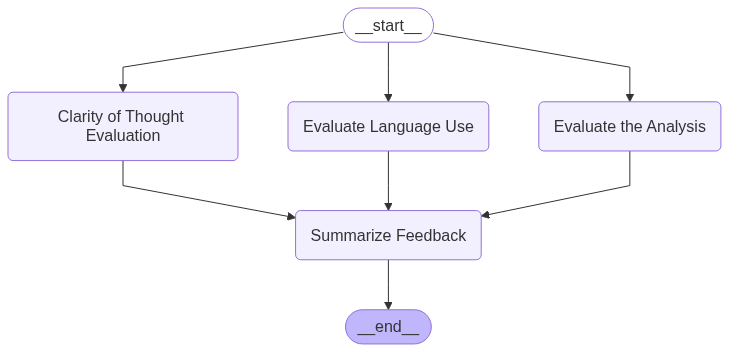

In [131]:
graph =StateGraph(essayState)
graph.add_node("Clarity of Thought Evaluation",clarity_of_thought)
graph.add_node("Evaluate the Analysis", evaluateAnalysis)
graph.add_node("Evaluate Language Use", evaluateLanguageUse)
graph.add_node("Summarize Feedback", summarizeFeedback)
graph.add_edge(START, "Clarity of Thought Evaluation")
graph.add_edge(START, "Evaluate the Analysis")
graph.add_edge(START, "Evaluate Language Use")
graph.add_edge('Clarity of Thought Evaluation', "Summarize Feedback")
graph.add_edge('Evaluate the Analysis', "Summarize Feedback")
graph.add_edge('Evaluate Language Use', "Summarize Feedback")
graph.add_edge("Summarize Feedback", END)

workflow = graph.compile()
workflow

In [132]:
essay = """
Corruption: A Threat to Progress and Justice

Corruption is one of the most pervasive issues affecting societies worldwide. It refers to the misuse of power, position, or resources for personal gain, often at the expense of fairness, justice, and development. While corruption can occur in both public and private sectors, it is most damaging when it infiltrates governance and institutions that are meant to protect citizens and uphold equality.

Causes of Corruption

Several factors contribute to the rise of corruption. One major cause is lack of transparency and accountability in government systems. When institutions operate without proper monitoring, it becomes easy for individuals to manipulate rules for personal benefits. Poverty and low wages also drive people to seek illegal means to fulfill their needs. Moreover, greed, weak law enforcement, and political interference further fuel corrupt practices. In many countries, a culture of favoritism and nepotism normalizes corruption, making it harder to eradicate.

Forms of Corruption

Corruption takes many forms. Bribery is the most common, where people pay money or offer gifts to get work done faster or illegally. Embezzlement occurs when officials misuse public funds for personal use. Fraud, extortion, and nepotism are other forms that damage trust in institutions. At a larger scale, political corruption—such as vote buying, manipulation of elections, and misuse of public resources—weakens democracy and threatens social justice.

Impact of Corruption

The effects of corruption are devastating. Economically, it hampers growth by discouraging foreign investments and misusing public money that should have been spent on development. Socially, corruption widens the gap between the rich and the poor, leaving vulnerable groups deprived of essential services like healthcare, education, and justice. Politically, it undermines democracy and erodes trust between citizens and the government. In short, corruption weakens the very foundation of a nation’s progress.

Solutions to Tackle Corruption

Fighting corruption requires a multi-pronged approach. Strict laws and punishments must be enforced against those involved in corrupt practices. Equally important is ensuring transparency and accountability in government processes through digital systems, audits, and independent watchdogs. Raising public awareness can empower citizens to resist and report corruption. Moreover, promoting ethical values, honesty, and integrity through education can shape a corruption-free mindset among future generations. International cooperation is also vital since corruption often crosses national boundaries.

Conclusion

Corruption is not just a financial crime; it is a moral and social disease that hinders growth, justice, and equality. While it may not be possible to eliminate it entirely, strong institutions, honest leadership, and active citizen participation can minimize its influence. Every individual has a role to play in fighting corruption—by refusing to participate in bribery, standing against injustice, and demanding accountability. A corruption-free society may be challenging to achieve, but it is essential for building a just, prosperous, and sustainable future.
"""

In [133]:
init_state = {
    'essay': essay,
    'feedback': [],
    'score': [],
    'final_score': 0,
    'Summarized_feedback': ""
}

final_state = workflow.invoke(init_state)
final_state

{'essay': '\nCorruption: A Threat to Progress and Justice\n\nCorruption is one of the most pervasive issues affecting societies worldwide. It refers to the misuse of power, position, or resources for personal gain, often at the expense of fairness, justice, and development. While corruption can occur in both public and private sectors, it is most damaging when it infiltrates governance and institutions that are meant to protect citizens and uphold equality.\n\nCauses of Corruption\n\nSeveral factors contribute to the rise of corruption. One major cause is lack of transparency and accountability in government systems. When institutions operate without proper monitoring, it becomes easy for individuals to manipulate rules for personal benefits. Poverty and low wages also drive people to seek illegal means to fulfill their needs. Moreover, greed, weak law enforcement, and political interference further fuel corrupt practices. In many countries, a culture of favoritism and nepotism normali